# In this tutorial we will build basic CNN for image classification.
Author :- Ankur Mali
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [114]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5510)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [115]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
79


# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [116]:
class Batch_Normalization(tf.keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-6, momentum=0.9):
        super(Batch_Normalization, self).__init__()

        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim
        self.it_call = 0
        self.batch_size = 0

        self.mean = self.add_weight("mean", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("variance", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        #print("@@@@@@@@@@@")
        
    
    def call(self, inputs, is_training=True):

        self.it_call += 1

        if is_training:   
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            batch_mean = tf.math.reduce_mean(inputs, axis=(0,1,2))
            batch_var = tf.math.reduce_variance(inputs, axis=(0,1,2))
            
            normalized_inputs = tf.math.divide((inputs - batch_mean), tf.math.sqrt(batch_var + self.epsilon))
            batch_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

    
            if inputs.shape[0] == self.batch_size:
                running_mean = batch_mean
                running_var = batch_var
            else:
                
                running_mean = batch_mean / inputs.shape[0] * self.batch_size
                running_var = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mean = running_mean * (self.momentum / self.it_call) + self.mean * (1 - (self.momentum/self.it_call))
            self.mean.assign(cur_mean)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else: 
            normalized_inputs = tf.math.divide((inputs - self.mean), tf.math.sqrt(self.var + self.epsilon))
            batch_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        #print("$$$$$$$$$")
        return batch_inputs

In [75]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.batchNorm = Batch_Normalization(64)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)

        x = self.batchNorm(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchNorm(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.batchNorm(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.batchNorm(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.conv8(x)
        
        x = tf.reshape(x, (-1, 1, 10)) #We need to reshape the shape to 10
        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    #def compute_accuracy(self, input_data):

      #""" Compute the accuracy on the input data.
    #     """
#with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [76]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

In [77]:
# Train model
isittraining =True
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=15, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  1.2922633
Train Acc at epoch 1:  0.93562436
Eval loss at epoch 1:  1.2734215
Eval Acc at epoch 1:  0.9358865
Train loss at epoch 2:  0.5431793
Train Acc at epoch 2:  0.945502
Eval loss at epoch 2:  0.52076757
Eval Acc at epoch 2:  0.95177525
Train loss at epoch 4:  0.16068445
Train Acc at epoch 4:  0.96385956
Eval loss at epoch 4:  0.15145473
Eval Acc at epoch 4:  0.9664048
Train loss at epoch 6:  0.08110071
Train Acc at epoch 6:  0.9722128
Eval loss at epoch 6:  0.079782404
Eval Acc at epoch 6:  0.97366536
Train loss at epoch 8:  0.04869705
Train Acc at epoch 8:  0.97717226
Eval loss at epoch 8:  0.05350789
Eval Acc at epoch 8:  0.97814876
Train loss at epoch 10:  0.033444755
Train Acc at epoch 10:  0.9805831
Eval loss at epoch 10:  0.04181576
Eval Acc at epoch 10:  0.9812765
Train loss at epoch 12:  0.023536766
Train Acc at epoch 12:  0.98309976
Eval loss at epoch 12:  0.035591427
Eval Acc at epoch 12:  0.9836437
Train loss at epoch 14:  0.016876753
Train Acc 

In [78]:
isittraining = False
test_acc = []
testacc = tf.keras.metrics.Mean('test_acc')
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy_2(images,target)
  testacc(accuracy)
  test_acc.append(testacc.result().numpy())

  testacc.reset_states()
print(np.mean(test_acc))

0.9863353


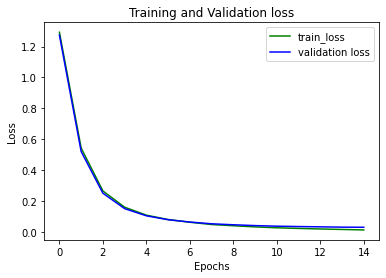

In [79]:
loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.batch_norm = Batch_Normalization(64)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = tf.nn.relu(x)
        x = self.batch_norm(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.batch_norm(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = tf.nn.relu(x)
        x = self.batch_norm(x)
        x = self.pool1(x)

        x = self.conv4(x)
        x = tf.nn.relu(x)
        x = self.batch_norm(x)
        x = self.pool1(x)

        x = self.conv8(x)
       
        x = tf.reshape(x, (-1, 1, 10))
     
        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                # training_data = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, True)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, True)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('\nTrain loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    plt.plot(i + 1, self.history['train_loss'][-1], linestyle = '-', marker = 'o', color = 'b', label = 'loss')
                    plt.plot(i + 1, self.history['train_acc'][-1], linestyle = '-', marker = 'o', color = 'r', label = 'accuracy')
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])
                    

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

            plt.show()    

In [118]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)


Train loss at epoch 1:  1.1271201
Train Acc at epoch 1:  0.94198513
Eval loss at epoch 1:  1.1085813
Eval Acc at epoch 1:  0.9409334

Train loss at epoch 2:  0.42864805
Train Acc at epoch 2:  0.94976026
Eval loss at epoch 2:  0.41402125
Eval Acc at epoch 2:  0.9557282

Train loss at epoch 4:  0.12206879
Train Acc at epoch 4:  0.9667956
Eval loss at epoch 4:  0.12097558
Eval Acc at epoch 4:  0.96922475

Train loss at epoch 6:  0.06026304
Train Acc at epoch 6:  0.974683
Eval loss at epoch 6:  0.06771097
Eval Acc at epoch 6:  0.9760491

Train loss at epoch 8:  0.035622973
Train Acc at epoch 8:  0.9794243
Eval loss at epoch 8:  0.04969321
Eval Acc at epoch 8:  0.9803749

Train loss at epoch 10:  0.023275735
Train Acc at epoch 10:  0.98272675
Eval loss at epoch 10:  0.04057456
Eval Acc at epoch 10:  0.9834053

Train loss at epoch 12:  0.014602627
Train Acc at epoch 12:  0.9851246
Eval loss at epoch 12:  0.036435124
Eval Acc at epoch 12:  0.98564225

Train loss at epoch 14:  0.009430645
Tra

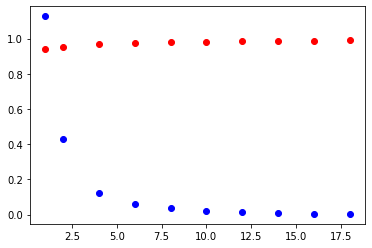

In [119]:
# Train model
isittraining =True
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True)

In [95]:
isittraining = False
test_acc = []
testacc = tf.keras.metrics.Mean('test_acc')
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy_2(images,target)
  testacc(accuracy)
  test_acc.append(testacc.result().numpy())

  testacc.reset_states()
print(np.mean(test_acc))

0.9889492


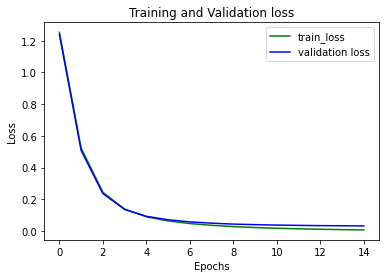

In [96]:
loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Running the model for the second time**



Train loss at epoch 1:  0.00059185
Train Acc at epoch 1:  0.992843
Eval loss at epoch 1:  0.03222122
Eval Acc at epoch 1:  0.99295026

Train loss at epoch 2:  0.0028078943
Train Acc at epoch 2:  0.9930437
Eval loss at epoch 2:  0.03427229
Eval Acc at epoch 2:  0.9931401

Train loss at epoch 4:  0.00055448693
Train Acc at epoch 4:  0.9934173
Eval loss at epoch 4:  0.02889108
Eval Acc at epoch 4:  0.99350816

Train loss at epoch 6:  0.00035511464
Train Acc at epoch 6:  0.993758
Eval loss at epoch 6:  0.029287824
Eval Acc at epoch 6:  0.9938379


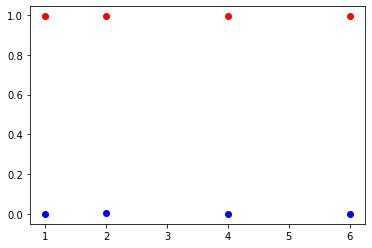

In [103]:
# Train model
isittraining =True
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=15, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True)

In [98]:
isittraining = False
test_acc = []
testacc = tf.keras.metrics.Mean('test_acc')
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy_2(images,target)
  testacc(accuracy)
  test_acc.append(testacc.result().numpy())

  testacc.reset_states()
print(np.mean(test_acc))

0.99195474


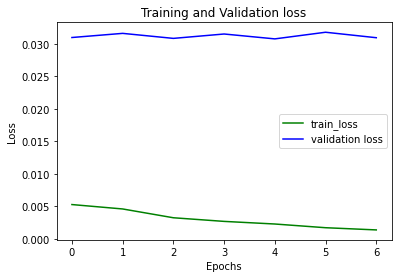

In [99]:
loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Running the model for third time



Train loss at epoch 1:  0.0010613758
Train Acc at epoch 1:  0.99210876
Eval loss at epoch 1:  0.03109356
Eval Acc at epoch 1:  0.9922487

Train loss at epoch 2:  0.00095269724
Train Acc at epoch 2:  0.99237716
Eval loss at epoch 2:  0.031557284
Eval Acc at epoch 2:  0.9925056


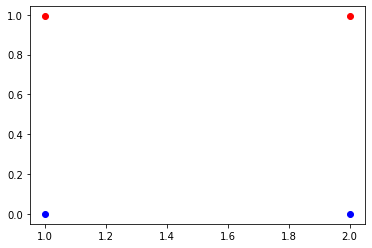

In [100]:
# Train model
isittraining =True
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=15, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True)

In [101]:
isittraining = False
test_acc = []
testacc = tf.keras.metrics.Mean('test_acc')
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy_2(images,target)
  testacc(accuracy)
  test_acc.append(testacc.result().numpy())

  testacc.reset_states()
print(np.mean(test_acc))

0.992724


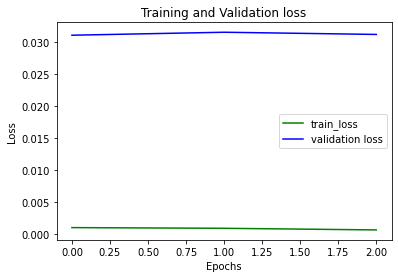

In [102]:
loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()